# Одномерная минимизация криловлинейной psf.
* поиск дальней точки через кепстр
* начальное приближение - полный перебор на срединном перпендикуляре
* уточнение одним из (стандартных) алгоритмов
<img src="pic/minimization_ill.png">

Время работы: 2:24

In [1]:
import numpy as np
from skimage import color, data, restoration, img_as_float, io
from scipy.signal import convolve2d as conv2

from skimage.restoration import richardson_lucy
from skimage.measure import compare_psnr
from functools import partial
from scipy.optimize import minimize
from scipy.optimize import OptimizeResult
from tqdm import tqdm_notebook

from util import *
from richardson_lucy import *

In [2]:
#astro = color.rgb2gray(data.astronaut())
original = img_as_float(color.rgb2gray(data.camera()))
#img_as_float(io.imread('original.png'))
iterations = 30

In [3]:
original.dtype

dtype('float64')

In [4]:
psf_drawn = img_as_float(io.imread("input/drawn-psf3.bmp"))
if len(psf_drawn.shape) == 3:
    psf_drawn = psf_drawn[:,:,0]
psf_drawn /= np.sum(psf_drawn)

In [5]:
lifting_drawn_blurred = convolve2d(original, psf_drawn, 'same')

deconv_orig = richardson_lucy_matlab(lifting_drawn_blurred, psf_drawn, iterations=iterations, 
                                     useFFT=True)#dampar=s_n, 
psnr_orig = compare_psnr_crop(original, deconv_orig['image'])

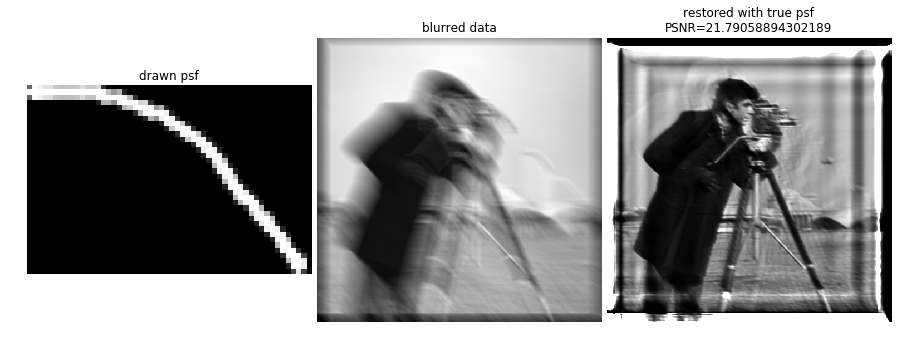

In [6]:
show_results(psf_drawn, lifting_drawn_blurred, deconv_orig['image'],
            titles=['drawn psf', 'blurred data', 'restored with true psf\nPSNR={0}'.format(psnr_orig)])

In [7]:
psf_drawn.shape

(36, 54)

In [8]:
s_n, S_find = find_noise(lifting_drawn_blurred)
s_n

0.00014466023330065022

In [9]:
N,M = lifting_drawn_blurred.shape
# ( ifft2 (100* log (1+ abs ( fft2 ( I ) ) ) ) ) ;
K = np.fft.ifftn(100*np.log(1+np.abs(np.fft.fftn(lifting_drawn_blurred))))
K_shift = np.fft.fftshift(K)

n, m, = K_shift.shape

#masksize = 10
K_shift[:, m//2] = 1
K_shift[n//2, :] = 1
#K_shift[n//2-masksize:n//2+masksize+1, m//2-masksize:m//2+masksize+1] = 1
mask_sigma = 2 # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
XX, YY = np.meshgrid(range(m), range(n))
gauss_mask = np.exp(-((XX-m//2)**2 + (YY-n//2)**2) / (2*mask_sigma**2))
K_shift += gauss_mask

c,r = np.unravel_index(np.argmin(np.real(K_shift), axis=None), K_shift.shape)
print(c,r)
x0_2 = np.array([r - n//2, c - m//2])

if x0_2[0]<0:
    x0_2 = -x0_2
x0_1 = x0_2/2# + np.array([4,-4])
x0 = np.concatenate((x0_1, x0_2))
print(x0)

222 204
[26. 17. 52. 34.]


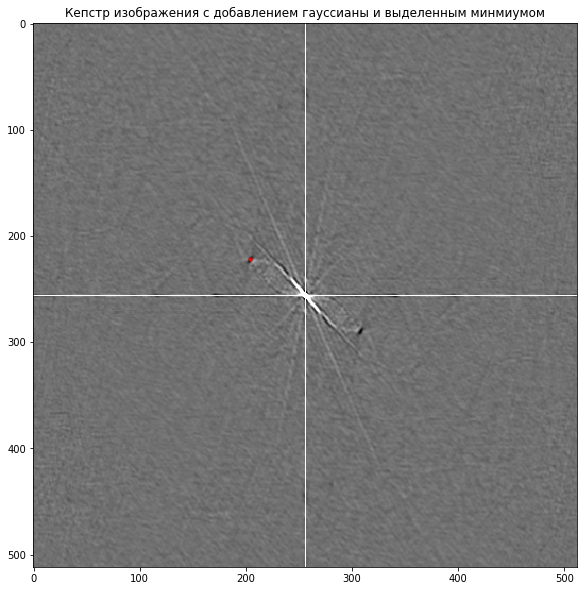

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(np.clip(np.real(K_shift), -1, 1), 'gray')#, vmin=noisy.min(), vmax=noisy.max())
#plt.plot(n//2 + x0_2[1], m//2 + x0_2[0], 'r.')
plt.plot(r, c, 'r.')
plt.title('Кепстр изображения с добавлением гауссианы и выделенным минмиумом')
plt.show()

In [11]:
K_shift[r,c]

(-0.05179451831471285-1.6354011032030223e-15j)

In [12]:
def second_point(x2, dist=0):
    n = np.array([x2[1], -x2[0]])
    n_len = vec_len(n)
    if n_len<1e-16:
        n = 1e-16
    else:
        n = n/vec_len(n)
    mid = x2 / 2
    return mid + n*dist

In [13]:
x1_vec = np.array([x0_2[1], -x0_2[0]])
x1_vec = x1_vec / vec_len(x1_vec)
print(x1_vec)

[ 0.54724936 -0.83696961]


In [14]:
def funcToMinimizeCurved2(xy, I_blurred, xy2, crop=100, *args, **kwargs):
    psf = bezier_psf2(np.concatenate((np.array(xy), np.array(xy2))), n=100)
    restored = richardson_lucy_matlab(I_blurred, psf, *args, **kwargs)
    I_restored = restored['image']
    df = convolve2d(I_restored, psf, 'same') - I_blurred
    return np.mean(np.square(df[crop:-crop, crop:-crop]))

In [15]:
def funcToMinimizeCurvedNormal(dist, I_blurred, xy2, crop=100, *args, **kwargs):
    xy = second_point(xy2, dist)
    print(dist, xy)
    
    psf = bezier_psf2(np.concatenate((np.array(xy), np.array(xy2))), n=100)
    restored = richardson_lucy_matlab(I_blurred, psf, *args, **kwargs)
    I_restored = restored['image']
    df = convolve2d(I_restored, psf, 'same') - I_blurred
    return np.mean(np.square(df[crop:-crop, crop:-crop]))

In [16]:
cost_fun = partial(funcToMinimizeCurvedNormal, I_blurred=lifting_drawn_blurred, xy2=x0_2, 
                   iterations=iterations, eps=1e-5, dampar=s_n, useFFT=True)

In [17]:
L = vec_len(x0_2)

In [18]:
distances = np.linspace(-L/2, L/2, 30)
best_val = 1e9 #+inf
best_dist = 0
for dist in distances:
    val = cost_fun(dist)
    if val < best_val:
        best_dist = dist
        best_val = val

-31.064449134018133 [ 9. 43.]
-28.922073331672056 [10.17241379 41.20689655]
-26.77969752932598 [11.34482759 39.4137931 ]
-24.6373217269799 [12.51724138 37.62068966]
-22.49494592463382 [13.68965517 35.82758621]
-20.352570122287744 [14.86206897 34.03448276]
-18.210194319941664 [16.03448276 32.24137931]
-16.067818517595587 [17.20689655 30.44827586]
-13.92544271524951 [18.37931034 28.65517241]
-11.783066912903433 [19.55172414 26.86206897]
-9.640691110557356 [20.72413793 25.06896552]
-7.498315308211275 [21.89655172 23.27586207]
-5.355939505865198 [23.06896552 21.48275862]
-3.213563703519121 [24.24137931 19.68965517]
-1.0711879011730403 [25.4137931  17.89655172]
1.0711879011730332 [26.5862069  16.10344828]
3.213563703519114 [27.75862069 14.31034483]
5.355939505865194 [28.93103448 12.51724138]
7.498315308211268 [30.10344828 10.72413793]
9.640691110557349 [31.27586207  8.93103448]
11.783066912903422 [32.44827586  7.13793103]
13.925442715249503 [33.62068966  5.34482759]
16.067818517595583 [34.7

In [19]:
best_dist, best_val

(31.064449134018133, 3.476867090831549e-05)

In [20]:
point2 = second_point(x0_2, best_dist)
points_found = np.concatenate((point2, x0_2))
print(points_found)

[43. -9. 52. 34.]


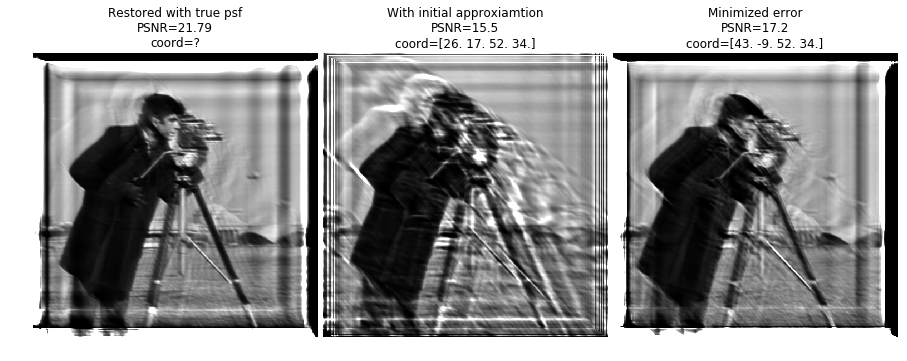

In [21]:
deconv_orig = richardson_lucy_matlab(lifting_drawn_blurred, psf_drawn, iterations=iterations, 
                                     dampar=s_n, useFFT=False)
psnr_orig = compare_psnr_crop(original, deconv_orig['image'])

psf_init = bezier_psf2(x0)
deconv_init = richardson_lucy_matlab(lifting_drawn_blurred, psf_init, iterations=iterations, 
                                     dampar=s_n, useFFT=False)
psnr_init = compare_psnr_crop(original, deconv_init['image'])

#points_found = res_my_grad2['x']
psf_found = bezier_psf2(points_found)
deconv_found = richardson_lucy_matlab(lifting_drawn_blurred, psf_found, iterations=iterations, 
                                      dampar=s_n, useFFT=False)
psnr_found = compare_psnr_crop(original, deconv_found['image'])

show_results(deconv_orig['image'], deconv_init['image'], deconv_found['image'],
             titles=['Restored with true psf\nPSNR={0}\ncoord=?'.format(psnr_orig.round(2)), 
                     'With initial approxiamtion\nPSNR={0}\ncoord={1}'.format(psnr_init.round(2), x0.round(4)),
                     'Minimized error\nPSNR={0}\ncoord={1}'.format(psnr_found.round(2), points_found.round(4))],
             savefig='pic/one-dim.png')

In [22]:
def funcToMinimizeCurved(xy, I_blurred, crop=100, *args, **kwargs):
    psf = bezier_psf2(xy, n=100)
    restored = richardson_lucy_matlab(I_blurred, psf, *args, **kwargs)
    I_restored = restored['image']
    df = convolve2d(I_restored, psf, 'same') - I_blurred
    return np.mean(np.square(df[crop:-crop, crop:-crop]))

In [23]:
res_nelder = minimize(partial(funcToMinimizeCurved, I_blurred=lifting_drawn_blurred, 
                              iterations=iterations, eps=1e-5, dampar=s_n, useFFT=True),
                      x0=points_found, method='Nelder-Mead', options={'xatol': 1e-4, 'disp': True})
print(res_nelder)

Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 32
         Function evaluations: 120
 final_simplex: (array([[44.84293213, -9.09151611, 49.97255859, 34.63210449],
       [44.8428806 , -9.09151728, 49.97258164, 34.63211273],
       [44.84291021, -9.09151616, 49.97257322, 34.63209005],
       [44.84291408, -9.09151221, 49.97257642, 34.63209604],
       [44.84293178, -9.09151508, 49.97257848, 34.63209383]]), array([3.01810545e-05, 3.01810545e-05, 3.01810545e-05, 3.01810545e-05,
       3.01810545e-05]))
           fun: 3.0181054474442926e-05
       message: 'Optimization terminated successfully.'
          nfev: 120
           nit: 32
        status: 0
       success: True
             x: array([44.84293213, -9.09151611, 49.97255859, 34.63210449])


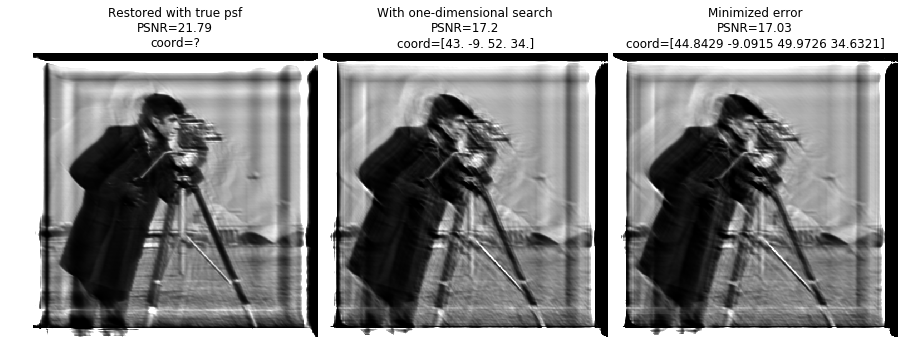

In [24]:
deconv_orig = richardson_lucy_matlab(lifting_drawn_blurred, psf_drawn, iterations=iterations, 
                                     dampar=s_n, useFFT=False)
psnr_orig = compare_psnr_crop(original, deconv_orig['image'])

psf_init = bezier_psf2(points_found)
deconv_init = richardson_lucy_matlab(lifting_drawn_blurred, psf_init, iterations=iterations, 
                                     dampar=s_n, useFFT=False)
psnr_init = compare_psnr_crop(original, deconv_init['image'])

#points_found = res_my_grad2['x']
points_found2 = res_nelder.x
psf_found = bezier_psf2(points_found2)
deconv_found = richardson_lucy_matlab(lifting_drawn_blurred, psf_found, iterations=iterations, 
                                      dampar=s_n, useFFT=False)
psnr_found = compare_psnr_crop(original, deconv_found['image'])

show_results(deconv_orig['image'], deconv_init['image'], deconv_found['image'],
             titles=['Restored with true psf\nPSNR={0}\ncoord=?'.format(psnr_orig.round(2)), 
                     'With one-dimensional search\nPSNR={0}\ncoord={1}'.format(psnr_init.round(2), points_found.round(4)),
                     'Minimized error\nPSNR={0}\ncoord={1}'.format(psnr_found.round(2), points_found2.round(4))],
             savefig='pic/one-dim-thiner.png')

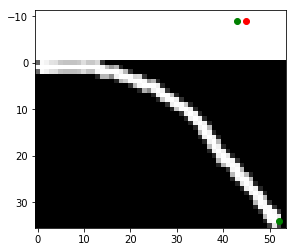

In [27]:
plt.imshow(psf_drawn)
plt.plot(points_found2[0], points_found2[1], 'ro')
plt.plot(points_found[0], points_found[1], 'go')
plt.plot(points_found[2], points_found[3], 'go')
plt.show()

In [26]:
psf_drawn.shape

(36, 54)